In [159]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as spla
# import torch
# import torchvision
import torchvision.datasets as datasets
from torchvision import transforms 
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
from numpy.polynomial.chebyshev import chebval
# from ml_collections import config_dict
import scipy.sparse as sparse
import os, sys
import time
from functools import partial
import ssgetpy
import copy
import warnings

root_dir = r'../..'
SEED = 42
TOL_FP = 1e-12

plt.rc('font', weight='bold', size=20) 
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=3, markersize=9)
mpl.rcParams['axes.grid'] = True

markers = ['o','^','s','p','d']
colors = ['b','g','r','c','m','y']

# Utils

In [160]:

def power_iteration(A, Omega,p, krylov=False):
    '''
    A: ndarray(shape=(m,n))
    Omega: ndarray(shape=(n,l))
    p: non-negative int
    Acol: ndarray(shape=(m,l)), ((A@A.T)**p)@A@Omega with orthonormalization
    '''
    A = A.astype(np.double)
    Omega = Omega.astype(np.double)
    l = Omega.shape[-1]
    X = (A@Omega).astype(np.double) #(m,l)
    Qcol,_ = spla.qr(X, mode='economic').astype(np.double) #(m,l)
    for iter in range(p):
        if krylov:
            Qrow,_ = spla.qr(A.T@Qcol, mode='economic') #(n,l*(iter+1))
            Qcol,_ = spla.qr(A @ np.hstack((Qrow,Omega)),mode='economic') #(m,l*(iter+2))
        else:
            Qrow,_ = spla.qr(A.T@Qcol[:,-l:], mode='economic') #(n,l)
            Qcol,_ = spla.qr(A@Qrow,mode='economic') #(m,l)
        Qrow = Qrow.astype(np.double)
        Qcol = Qcol.astype(np.double)
    return Qcol.astype(np.double)


def rsvd(A, k, l=None, power_iter=0, algo='rsvd', return_Omega=0, 
         embedding=lambda d,l: np.random.randn(d,l)/np.sqrt(l)):
    '''
    * algo: 'rsvd'(default, Halko2011), 'gn'(generalized Nystrom), 'bk'(block Krylov)
    * return_Omega: 0 = not return, 1 = return embedding, 2 = return embedding + distribution
    '''
    A = A.astype(np.double)
    if l is None:
        l = min(k+10, A.shape[1])

    # construct low-rank approximation
    if algo=='bk': # block krylov (ignoring l)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter,krylov=True) #(m,l*(p+1))
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False) #(l*(p+1),l*(p+1)),(l*(p+1),),(l*(p+1),n)
        Uap = (Qcol @ Uap_reduced).astype(np.double) #(m,l*(p+1))
    elif algo=='gn': # generalized Nystrom
        l_large = np.ceil(1.5*k)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Gamma = embedding(A.shape[0],l_large).astype(np.double) #(m,l_large)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Qrow = power_iteration(A.T,Gamma,0) #(n,l_large)
        core = ((Qcol.T @ A) @ Qrow).astype(np.double) #(l,l_large)
        Uap_reduced, sap, Vhap_reduced = spla.svd(core, full_matrices=False) #(l,l),(l,),(l,l_large)
        Uap = (Qcol @ Uap_reduced).astype(np.double) #(m,l)
        Vhap = (Vhap_reduced @ Qrow.T).astype(np.double) #(l,n)
    else: # rsvd
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False) #(l,l),(l,),(l,n)
        Uap = (Qcol @ Uap_reduced).astype(np.double) #(m,l)
    
    # output
    if return_Omega==1:
        return Uap, sap, Vhap, Omega
    elif return_Omega==2:
        return Uap, sap, Vhap, Omega, embedding
    else:
        return Uap, sap, Vhap


def lupp(A):
    '''
    A of size mxk with rank k and m >= k
    
    A[p,:] = L@U
    p: ndarray(shape=(m,), dtype=int)
    L: ndarray(shape=(m,k), dtype=float)
    U: ndarray(shape=(k,k), dtype=float)
    '''
    A = A.astype(np.double)
    P, L, U = spla.lu(A)
    p = (P.T @ np.arange(A.shape[0]).reshape(-1,1)).astype(int).reshape(-1)
    return L.astype(np.double), U.astype(np.double), p


def cpqr(A):
    '''
    A of size kxn with rank k and n >= k
    
    A[:,p] = Q@R
    p: ndarray(shape=(n,), dtype=int)
    Q: ndarray(shape=(k,k), dtype=float)
    R: ndarray(shape=(k,n), dtype=float)
    '''
    A = A.astype(np.double)
    Q,R,p = spla.qr(A, mode='economic', pivoting=True)
    return Q.astype(np.double), R.astype(np.double), p.astype(int)


def stable_id_error(A, row_idx, timing=False, ord='fro'):
    A = A.astype(np.double)
    R = A[row_idx,:] #(k,n)
    t0 = time.time()
    Qr, _ = spla.qr(R.T, mode='economic') #(n,k)
    Qr = Qr.astype(np.double)
    A_sid = (A @ Qr) @ Qr.T 
    dt = time.time() - t0
    error = spla.norm(A - A_sid, ord=ord)
    if timing:
        return error, dt
    else:
        return error


def matdivide(A, B, compute_spectrum=False, tol=TOL_FP):
    '''
    A: (m,n) ndarray
    B: (k,n) ndarray
    compute A*pinv(B), or its spectrum
    '''
    A = A.astype(np.double)
    B = B.astype(np.double)
    U,s,Vh = spla.svd(B, full_matrices=False)
    r = np.count_nonzero(s>tol)
    Aux = ((A @ Vh[:r].T)/(s[:r].reshape(1,-1))).astype(np.double) #(m,r)
    if compute_spectrum:
        spectrum = spla.svd(Aux, compute_uv=False)
        return spectrum
    else:
        return (Aux @ U[:,:r].T).astype(np.double) #(m,k)
    

def stable_chol_divide(A, B, tol=TOL_FP):
    '''
    A: (n,b) ndarray
    B: (b,b) ndarray, symmetric
    compute A*chol(B), or its spectrum
    '''
    A = A.astype(np.double)
    B = B.astype(np.double)
    evals, V = spla.eigh(B)
    mask = evals > tol
    evals, V = evals[mask], V[:,mask] #(r,), (b,r)
    output = (A @ V) @ (V / np.sqrt(evals)).T #(n,b)
    return output


def canonical_angles(U,V, check_ortho=True, tol=TOL_FP):
    '''
    Input
    -----
    * U: ndarray(shape=(d,k)) (d>k)
    * V: ndarray(shape=(d,l)) (d>l)
    Output
    ------
    * min(k,l) sin's and cos's, descending
    '''
    U = U.astype(np.double)
    V = V.astype(np.double)
    if check_ortho:
        U,_ = spla.qr(U, mode='economic')
        V,_ = spla.qr(V, mode='economic')
    Mcos = (U.T @ V).astype(np.double) # (k,l)
    cos = spla.svd(Mcos, full_matrices=False, compute_uv=False)
    if cos[0]>=1. or cos[-1]<tol: # compute sin instead for highly overlapped (U,V)
        if U.shape[-1]>V.shape[-1]: #k>l
            Msin = V - U @ Mcos #(d,l)
        else: #l>=k
            Msin = U - V @ Mcos.T #(d,k)
        sin = spla.svd(Msin, full_matrices=False, compute_uv=False)
        return np.flip(sin)
    else:
        return np.sqrt(1.-cos**2)
    

get_sketch = lambda A, sample_size: A @ (np.random.randn(A.shape[1], sample_size)/np.sqrt(sample_size)).astype(np.double)

# Target matrices
## Featch [SparseSuite](https://sparse.tamu.edu/)

In [161]:
# https://sparse.tamu.edu/Meszaros/large
# results = ssgetpy.search(
#     rowbounds = (4200, 4300), # 4,282
#     colbounds = (8600, 8700), # 8,617
#     nzbounds = (20600, 20800), # 20,635
#     isspd = False,
#     dtype = None,
#     group = None,
#     kind = None,
#     limit = 10,
# )
# large = results[0]
# large.download(destpath=os.path.join(root_dir, 'dataset'))


## Formating

Files already downloaded and verified


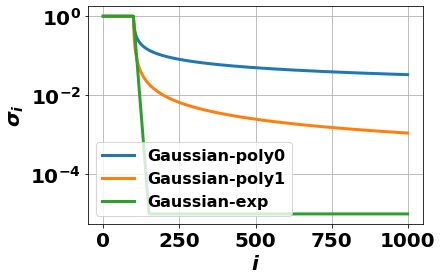

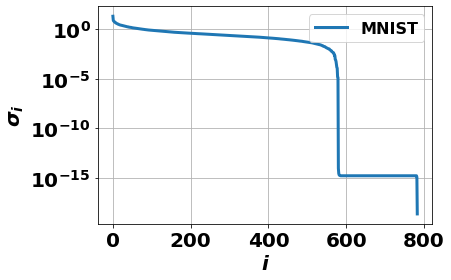

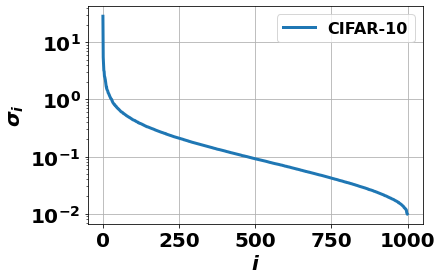

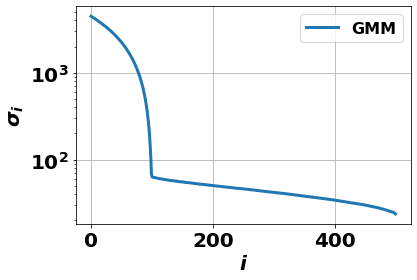

odict_keys(['Gaussian-poly0', 'Gaussian-poly1', 'Gaussian-exp', 'SNN_m1000n1000r100a10', 'SNN_m1000n1000r100a1', 'MNIST', 'cifar10', 'gmm'])


In [147]:
def genenrate_mnist_target(size=1000):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    dataset = datasets.MNIST(root=os.path.join(root_dir,'dataset'), train=False, download=True, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=size, shuffle=True)
    X,_ = next(iter(dataloader))
    X = X.view(size,-1).numpy().astype(np.double)
    X = X / spla.norm(X, ord=2, axis=1, keepdims=True)
    U,s,Vh = spla.svd(X, full_matrices=False)
    target = {'A': X.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': 'mnist-train%d'%(size)}
    return target


def genenrate_cifar10_target(size=1000):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    dataset = datasets.CIFAR10(root=os.path.join(root_dir,'dataset'), train=False, download=True, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=size, shuffle=True)
    X,_ = next(iter(dataloader))
    X = X.view(size,-1).numpy().astype(np.double)
    X = X / spla.norm(X, ord=2, axis=1, keepdims=True)
    U,s,Vh = spla.svd(X, full_matrices=False)
    target = {'A': X.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': 'mnist-train%d'%(size)}
    return target


def genenrate_gmm_target(n=1000, d=1000, n_cluster=100, sigma=1.0):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    X = np.repeat((10 * np.arange(1, 1+n_cluster)).reshape(-1,1) * np.eye(d)[:n_cluster], repeats=n//n_cluster, axis=0) # cluster centers
    n, d = X.shape
    X += np.random.randn(n,d) * sigma
    U,s,Vh = spla.svd(X, full_matrices=False)
    target = {'A': X.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': f'gmm-n{n}d{d}k{n_cluster}sig{sigma:.0e}'}
    return target


def genenrate_gaussian_target(m=1000, n=1000, rank=1000, spectrum=None):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    if spectrum is None:
        spectrum = np.linspace(1.0, 1e-5, num=rank)
    elif len(spectrum)<rank:
        spectrum = np.concatenate((spectrum, np.zeros(rank-len(spectrum))))
    U,_ = spla.qr(np.random.randn(m,rank), mode='economic')
    V,_ = spla.qr(np.random.randn(n,rank), mode='economic')
    target = {'A': (( U*(spectrum[:rank].reshape((1,-1))) )@V.T).astype(np.double), 
              'U': U.astype(np.double), 
              's': spectrum[:rank].astype(np.double),
              'V': V.astype(np.double),
              'tag': 'Gaussian'}
    return target


def generate_sparse_nonnegative_target(m=1000, n=1000, r1=100, amp=1., sparsity=0.1):
    r = min(m,n)
    weights = np.concatenate((amp/np.arange(1,r1+1), 1./np.arange(r1+1,r+1))) #(r,)
    X = sparse.random(m, r, density=sparsity, format='csr').toarray()
    Y = sparse.random(r, n, density=sparsity, format='csr').toarray()
    A = (X@(weights*Y))
    U,s,Vh = spla.svd(A, full_matrices=False)
    target = {'A': A.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': f'SNN-m{m:d}n{n:d}r{r1:d}a{amp:.0f}'}
    return target


def visualize_spec(spectra, range=100):
    plt.figure()
    for name, spec in spectra.items():
        plt.semilogy(spec[:range], label=name)
    plt.xlabel('$i$')
    plt.ylabel('$\sigma_i$')
    plt.legend()
    plt.show()


def get_targets(m=1000, n=1000, r1=100, verbose=False, tol=1e-5):
    spectra= {  'poly0': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**.5))),
                'poly1': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./np.arange(2,r-r1+2)))),
                'poly2': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**2))),
                'exp': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,0.8**(np.arange(1,r-r1+1))))),
              }
    targets = OrderedDict()
    # Gaussian random
    spectra_gaussian = dict()
    r = min(m,n)
    for decay in ['poly0','poly1','exp']:
        tag = f'Gaussian-{decay:s}'
        targets[tag] = genenrate_gaussian_target(m=m, n=n, rank=r, spectrum=spectra[decay](r))
        targets[tag]['tag'] = tag 
        spectra_gaussian[tag] = targets[tag]['s']
    
    # SNN
    spectra_snn = dict()
    for amp in [10,1]:
        tag = f'SNN_m{m:d}n{n:d}r{r1:d}a{amp:.0f}'
        targets[tag] = generate_sparse_nonnegative_target(m, n, r1, amp, sparsity=0.1)
        spectra_snn[tag] = targets[tag]['s']
    
    # MNIST
    targets['MNIST'] = genenrate_mnist_target(size=m)
    
    # CIFAR-10
    targets['cifar10'] = genenrate_cifar10_target(size=m)
    
    # GMM
    targets['gmm'] = genenrate_gmm_target(n=2000, d=500, n_cluster=100, sigma=1.0)
    
    if verbose:
        visualize_spec(spectra_gaussian, range=1000)
        # visualize_spec(spectra_snn, range=100)
        visualize_spec({'MNIST':targets['MNIST']['s']}, range=1000)
        visualize_spec({'CIFAR-10':targets['cifar10']['s']}, range=1000)
        visualize_spec({'GMM':targets['gmm']['s']}, range=1000)

    return targets


targets = get_targets(verbose=True)
print(targets.keys())

# Sketchy LUPP/CPQR

In [163]:
def interpolation(A, row_perm, k, Y=None, oversampling=1.0, mode='sid', timing=True):
    '''
    * A: (m,n)
    * row_perm: (m,)
    * k: int
    * Y: (m,?), treated as the triangular matrix from LUPP/CPQR if mode=='id'
    '''
    l = int(np.ceil(k*oversampling)) 
    if mode in ['qrid', 'fsid']:
        Y = get_sketch(A, l).astype(np.double) if Y is None else Y[:,:l]
        
    t0 = time.time()
    if mode=='qrid':
        R = spla.qr(Y[row_perm][:,:l].T, mode='r') #cost: (ml^2)
        R = R[0] #(k,m)
        R1 = R[:k,:k] #(k,k)
        R2 = R[:k,k:] #(k,m-k)
        W_perm_sub = spla.solve_triangular(R1, R2).T #(m-k,k)
    elif mode=='sid':
        As = A[row_perm[:k]].T #(n,k)
        Q, R = spla.qr(As, mode='economic',) #(n,k), (k,k)
        W_perm_sub = spla.solve_triangular(R, (A[row_perm[k:]]@Q).T).T #(m-k,k)
    elif mode=='fsid':
        Ys = Y[row_perm[:k],:l].T #(l,k)
        Q, R = spla.qr(Ys, mode='economic',) #(l,k), (k,k)
        W_perm_sub = spla.solve_triangular(R, (Y[row_perm[k:],:l]@Q).T).T #(m-k,k)
    elif mode=='id':
        L = Y
        W_perm_sub = spla.solve_triangular(L[:k,:k].T, L[k:,:k].T).T
    else:
        raise RuntimeError(f"Algorithm '{mode}' not recognized")
    dt = time.time() - t0
        
    if timing:
        return W_perm_sub, dt
    else:
        return W_perm_sub


def id_error(X, row_perm, W_perm_sub, mode='ls'):
    '''
    * mode
        - psd: trace of PSD matrix X @ X.T - W @ Xs @ (W @ Xs).T
        - ls: least square / Frobenius norm error of A
    '''
    k = len(row_perm) - W_perm_sub.shape[0]
    if mode=='psd':
        err = spla.norm(X[row_perm[k:]], ord='fro')**2 - spla.norm(W_perm_sub @ X[row_perm[:k]], ord='fro')**2
    elif mode=='ls':
        err = spla.norm(X[row_perm[k:]] - W_perm_sub @ X[row_perm[:k]], ord='fro')**2
    else:
        raise RuntimeError(f"Error metric '{mode}' not recognized")
    return err


def lupp_uest(U, num_pts, k, u_est_offset=5):
    t0 = time.time()
    if k<np.min(U.shape):
        offset = min(k + u_est_offset, np.min(U.shape))-k
        # u_est = spla.norm(U[r,r:], ord=2)
        # u_est = spla.norm(U[r:,r:], axis=1, ord=2).max()
        # u_est = spla.norm(U[r:,r:], ord='fro')
        # u_est = spla.norm(U[r, r:], ord=2)
        # u_est = spla.norm(U[r:r+offset, r:r+offset], axis=1, ord=2).max()
        u_est = spla.norm(U[k:k+offset, k:k+offset], ord='fro')
    else:
        offset = 1
        u_est = np.abs(U[-1,-1])
    dt = time.time() - t0
    err_est = u_est * np.sqrt((num_pts-k) * offset)
    return err_est, dt
    

def get_id_error(
    A, ranks, oversampling=1.0, u_est_offset=5,
    modes=['lupp', 'cpqr', 'detcpqr'], 
    errtags = ['id', 'sid', 'fsid', 'uest'], # psid
):
    A = A.astype(np.double)   
    error_ref = spla.norm(A, ord='fro')**2
    k_max = np.max(ranks)
    t0 = time.time()
    Y = get_sketch(A, min(k_max*2, A.shape[1])).astype(np.double)
    dt_sketch_unit = (time.time() - t0) / Y.shape[1]
    errors = dict()
    times = dict()
    
    for mode in modes:
        if mode=='lupp':        
            def _lupp_error_time(errtag):
                errs_id = []
                dts_id = []
                for k in ranks:
                    t0 = time.time()
                    L, U, row_perm = lupp(Y[:,:k]) #(m,k) cost: (mk^2)
                    dt_pivot = time.time() - t0
                    
                    if errtag=='uest':
                        err_id, dt_id = lupp_uest(U, A.shape[0], k, u_est_offset=u_est_offset)
                    elif errtag=='psid':
                        err_id, dt_id = stable_id_error(A, row_perm[:k], timing=True)
                    elif errtag=='id':
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=L, mode=errtag)
                        err_id = id_error(A, row_perm, W_perm_sub)
                    else:
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=Y, oversampling=oversampling, mode=errtag,)
                        err_id = id_error(A, row_perm, W_perm_sub)
                    errs_id.append(err_id)  
                    
                    if errtag=='fsid':
                        dts_id.append(dt_pivot + dt_id + dt_sketch_unit*np.ceil(k*oversampling))
                    else:
                        dts_id.append(dt_pivot + dt_id + dt_sketch_unit*k)
                return np.array(errs_id), np.array(dts_id)
            
            for errtag in errtags:
                tag = f'{mode}_{errtag}'
                errs_id, dts_id = _lupp_error_time(errtag)
                errors[tag] = errs_id / error_ref
                times[tag] = dts_id
                
        elif mode=='cpqr':
            def _cpqr_error_time(errtag):
                errs_id = []
                dts_id = []
                for k in ranks:
                    t0 = time.time()
                    _, R, row_perm = cpqr(Y[:,:k].T) #R:(k,m) # QR has to be computed per-rank since each pivot is determined by a global search
                    dt_pivot = time.time() - t0
                    
                    if errtag=='id':
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=R.T, mode=errtag) #(m-k,k)
                    else:
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=Y, oversampling=oversampling, mode=errtag,)
                    errs_id.append(id_error(A, row_perm, W_perm_sub))  
                    
                    if errtag=='fsid':
                        dts_id.append(dt_pivot + dt_id + dt_sketch_unit*np.ceil(k*oversampling))
                    else:
                        dts_id.append(dt_pivot + dt_id + dt_sketch_unit*k)
                return np.array(errs_id), np.array(dts_id)
            
            for errtag in errtags:
                if errtag in ['id','sid','fsid']:
                    tag = f'{mode}_{errtag}'
                    errs_id, dts = _cpqr_error_time(errtag)
                    errors[tag] = errs_id / error_ref
                    times[tag] = dts
                
        elif mode=='detcpqr':        
            def _id_error_time(errtag):
                errs_id = []
                dts_id = []
                
                t0 = time.time()
                _, R, row_perm = cpqr(A.T) #(m,m) if m<n else (n,m)
                dt_pivot = time.time() - t0
            
                for k in ranks:
                    if errtag=='id':
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=R[:k].T, mode=errtag)
                    else:
                        W_perm_sub, dt_id = interpolation(A, row_perm, k, Y=Y, oversampling=oversampling, mode=errtag,)
                    err_id = id_error(A, row_perm, W_perm_sub)
                    errs_id.append(err_id)  
                    dts_id.append(dt_pivot + dt_id)
                return np.array(errs_id), np.array(dts_id)
            
            for errtag in errtags:
                if errtag in ['id','sid']:
                    tag = f'{mode}_{errtag}'
                    errs_id, dts_id = _id_error_time(errtag)
                    errors[tag] = errs_id / error_ref
                    times[tag] = dts_id
            
        else:
            raise RuntimeError(f"Pivoting method '{mode}' not recognized")
    
    return errors, times

# Cholesky ID
The following functions adapt [the implementation of (blocked) RPCholesky](https://github.com/eepperly/Randomly-Pivoted-Cholesky/blob/main/rp_cholesky.py) for PSD matrices to Cholesky ID for generic matrices.

In [164]:
def cholid(X, k, tol=None, mode='rp', ortho=0):
    '''
    * X: ndarray(n,d)
    * k: target rank
    * mode: choices=['rp','gp']
    * ortho: whether using ORP/OGP
        - ortho==0: RP/GP, faster when n < d
        - ortho==1: ORP/OGP, faster when n > d
    '''
    X = X.astype(np.double)
    n, d = X.shape
    row_perm = np.arange(n)
    rng = np.random.default_rng(seed=SEED)
    
    t0 = time.time()
    diags = spla.norm(X, ord=2, axis=1).astype(np.double)**2 #(n,)
    residual = sum(diags)
    dt_init = time.time() - t0
    time_pivot = [dt_init]
    
    L = np.zeros((n,k)).astype(np.double)
    Q = np.zeros((d,k))
    residuals = [residual]
    for i in range(k):
        t0 = time.time()
        candidates = row_perm[i:]
        if mode == 'rp':
            j = i + rng.choice(n-i, p = diags[candidates] / sum(diags[candidates]))
        elif mode == 'gp':
            j = i + rng.choice(np.where(diags[candidates] == np.max(diags[candidates]))[0])
        else:
            raise RuntimeError(f"Algorithm '{mode}' not recognized")
        row_perm[[i, j]] = row_perm[[j, i]]
        idx = row_perm[i]
        
        if ortho==1:
            if i==0:
                v = X[idx]
            else:
                v = X[idx] - Q[:,:i] @ (Q[:,:i].T @ X[idx])
            Q[:,i] = v / np.sqrt(np.sum(v**2))
            a = X[row_perm[i:]] @ v
        elif ortho==0:
            a = X[row_perm[i:]] @ X[idx].T - L[row_perm[i:],:i] @ L[idx,:i].T
        else:
            raise RuntimeError(f"ortho='{ortho}' not recognized")
        L[row_perm[i:],i] = (a / np.sqrt(a[0])).astype(np.double)
        # L[row_perm[i:],i] = (a / np.sqrt(diags[idx])).astype(np.double)
        
        diags[row_perm[i+1:]] -= L[row_perm[i+1:],i]**2    
        diags[idx] = 0 # for sanity only
        diags = diags.clip(min=0)
        diags = diags.astype(np.double)
        residual = sum(diags[row_perm[i+1:]])
        time_pivot.append(time.time() - t0 + time_pivot[-1])
        
        residuals.append(residual)
        if (tol is not None and residual < residuals[0] * tol) or (np.count_nonzero(diags[row_perm[i+1:]]) < 1):
            L = L[:,:i+1]
            # Q = Q[:,:i+1]
            break
        
    residuals = np.array(residuals[1:])/residuals[0]
    time_pivot = np.array(time_pivot[1:])
    
    return row_perm, L, residuals, time_pivot


def _block_size_local_clip(R, tol,):
    rncs = np.flip(np.flip(spla.norm(R, ord=2, axis=1)**2).cumsum()) # row norms cumsum
    relative_rncs = rncs / rncs[0]
    block_size = R.shape[0] if relative_rncs[-1] >= tol else np.argmax(relative_rncs < tol)
    return block_size


def blocked_cholid(X, k, b=20, tol=None, mode='rp', ortho=1, tol_loc=None):
    '''
    * X: ndarray(n,d)
    * k: target rank
    * mode: choices=['rp','gp']
    * ortho: whether using ORP/OGP
        - ortho==0: RP/GP, unstable
        - ortho==1: ORP/OGP, orthogonalization, block lower triangular L, approximated, most stable with solve_triangular(L1.T, L2.T).T
        - ortho==2: O2RP/O2GP, orthogonalization, lower triangular L, exact, more stable with SVD
    '''
    X = X.astype(np.double)
    n, d = X.shape
    row_perm = np.arange(n)
    rng = np.random.default_rng(seed=SEED)
    tol_loc = 1/b if tol_loc is None else tol_loc
    
    t0 = time.time()
    diags = spla.norm(X, ord=2, axis=1).astype(np.double)**2 #(n,)
    residual = sum(diags)
    dt_init = time.time() - t0
    time_pivot = [dt_init]
    
    L = np.zeros((n,k)).astype(np.double)
    Q = np.zeros((d,k))
    residuals = [residual]
    ranks = []
    
    i = 0
    while i < k:
        t0 = time.time()
        block_size = min(k-i, b, np.count_nonzero(diags[row_perm[i:]]))
        if mode == 'rp':
            js = i + rng.choice(n-i, size=block_size, p = diags[row_perm[i:]] / sum(diags[row_perm[i:]]), replace=False)
            # js = np.unique(js)[:block_size]
            block_size = len(js)
        elif mode == 'gp':
            js = i + np.argpartition(diags[row_perm[i:]], -block_size)[-block_size:]
        else:
            raise RuntimeError(f"Algorithm '{mode}' not recognized")
        
        if ortho>0:
            if i==0:
                V = X[row_perm[js]].T #(d,b)
            else:
                V = X[row_perm[js]].T - Q[:,:i] @ (Q[:,:i].T @ X[row_perm[js]].T) #(d,b), cost = O(dbi)
            
            QV, RV, pV = spla.qr(V, mode='economic', pivoting=True) #(d,b), (b,b), (b,)
            block_size = _block_size_local_clip(RV, tol_loc)
            js = js[pV[:block_size]]
            row_perm[i:i+block_size], row_perm[js] = row_perm[js], row_perm[i:i+block_size]      
            Q[:,i:i+block_size] = QV[:,:block_size]
            
            if ortho==1:
                L[row_perm[i:],i:i+block_size] = X[row_perm[i:]] @ Q[:,i:i+block_size]
            elif ortho==2:
                QL, RL = spla.qr((X[row_perm[i:]] @ Q[:,i:i+block_size]).T, mode='economic') #(b,b), (b,n-i) 
                L[row_perm[i:],i:i+block_size] = RL.T #(n-i,b)
                # Q[:,i:i+block_size] = QV @ QL #(d,b) # unstable
            else:
                raise RuntimeError(f"ortho='{ortho}' not recognized")
        
        elif ortho==0:
            A = X[row_perm[i:]] @ X[row_perm[js]].T - L[row_perm[i:],:i] @ L[row_perm[js],:i].T #(n-i,b)
            
            _, RA, pA = spla.qr(A, mode='economic', pivoting=True) #(d,b), (b,b), (b,)
            block_size = _block_size_local_clip(RA, tol_loc**2)
            js = js[pA[:block_size]]
            
            # R = spla.cholesky(A[js-i][:,pA[:block_size]] + 1e-8 * np.eye(block_size))
            # L[row_perm[i:], i:i+block_size] = spla.solve_triangular(R, A[:,pA[:block_size]].T).T #(n-i,b)
            L[row_perm[i:], i:i+block_size] = stable_chol_divide(A[:,pA[:block_size]], A[js-i][:,pA[:block_size]])
            row_perm[i:i+block_size], row_perm[js] = row_perm[js], row_perm[i:i+block_size]
        else:
            raise RuntimeError(f"ortho='{ortho}' not recognized")
        
        diags[row_perm[i+block_size:]] -= np.sum(L[row_perm[i+block_size:],i:i+block_size]**2, axis=1)
        # diags[row_perm[:i+block_size]] = 0 # for sanity only
        diags = diags.clip(min=0)
        diags = diags.astype(np.double)
        residual = sum(diags[row_perm[i+block_size:]])
        i += block_size
        time_pivot.append(time.time() - t0 + time_pivot[-1])
        
        residuals.append(residual)
        ranks.append(i)
        if (tol is not None and residual < residuals[0] * tol) or (np.count_nonzero(diags[row_perm[i+1:]]) < 1):
            L = L[:,:i]
            # Q = Q[:,:i]
            break
        
    residuals = np.array(residuals[1:])/residuals[0]
    ranks = np.array(ranks, dtype=int)
    time_pivot = np.array(time_pivot[1:])
    
    return row_perm, L, residuals, time_pivot, ranks
    

def get_cholid_error(
    X, ranks, tol=None, ortho=0, b=1, tol_loc=None,
    mode='rp', 
    errtags=['res', 'id', 'sid'],
    cond_tol = 1/TOL_FP,
):
    X = X.astype(np.double)   
    error_ref = spla.norm(X, ord='fro')**2
    k_max = np.max(ranks)
    errors = dict()
    times = dict()
    
    if b==1:
        row_perm, L, residuals, time_pivot = cholid(X, k_max, tol=tol, mode=mode, ortho=ortho)
        ranks = ranks[ranks <= L.shape[1]]
    elif b>1:
        row_perm, L, residuals, time_pivot, ranks = blocked_cholid(X, k_max, b=b, tol=tol, mode=mode, ortho=ortho, tol_loc=tol_loc)
    else:
        raise RuntimeError(f"Block size {b} < 1 not applicable")
    
    if ortho==0:
        tag_ortho = ''
    elif ortho==1:
        tag_ortho = 'o'  
    elif ortho==2:
        tag_ortho = 'o2'
    else:
        raise RuntimeError(f"ortho='{ortho}' not recognized")
        
    block_tag = '' if b==1 else 'b'
    algo_tag = block_tag + tag_ortho + mode
    print(algo_tag)
        
    if 'res' in errtags:
        tag = algo_tag + '_res'
        errors[tag] = residuals[ranks-1] if b==1 else residuals
        times[tag] = time_pivot[ranks-1] if b==1 else time_pivot
    
    if 'id' in errtags:
        tag = algo_tag + '_id'
        errors[tag] = []
        times[tag] = []
        use_svd = []
        cond_L1 = 1
        
        for k in ranks:
            L = L.astype(np.double)
            L1, L2 = L[row_perm[:k], :k], L[row_perm[k:], :k] #(k,k), (n-k,k)
            
            t0 = time.time()
            if cond_L1 < cond_tol:
                cond_L1 = np.linalg.cond(L1)
            if (b<2 or ortho==2) and (cond_L1 < cond_tol): # L1 lower triangular # if len(use_svd)==0 or use_svd[-1]!=k: 
                W_perm_sub = spla.solve_triangular(L1.T, L2.T).T #(n-k,k)
            else: # L1 b-block triangular
                use_svd.append(k)
                W_perm_sub = matdivide(L2, L1) #(n-k,k)
            times[tag].append(time.time() - t0)
            errors[tag].append(id_error(X, row_perm, W_perm_sub))
            print(f"k = {k:4d}, cond = {cond_L1:10.2e}, min L1 = {np.min(np.abs(L1)):10.2e}, max L1 = {np.max(np.abs(L1)):10.2e}")
            
        if len(use_svd):
            warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))
        
        times[tag] = np.array(times[tag]) + (time_pivot[ranks-1] if b==1 else time_pivot)
        errors[tag] = np.array(errors[tag])/error_ref
    
    if 'sid' in errtags:
        tag = algo_tag + '_sid'
        errors[tag] = []
        times[tag] = []
        for k in ranks:
            W_perm_sub, dt_id = interpolation(X, row_perm, k, mode='sid') #(n-k,k)
            times[tag].append(dt_id)
            errors[tag].append(id_error(X, row_perm, W_perm_sub))
        times[tag] = np.array(times[tag]) + (time_pivot[ranks-1] if b==1 else time_pivot)
        errors[tag] = np.array(errors[tag])/error_ref
    
    return errors, times, ranks

# Test ID

In [226]:
RANK_MAX_RATIO = 0.4

def _merge_ranks(ranks1, ranks2):
    return np.unique(np.concatenate((ranks1, ranks2)))

def compare_skeletonization_errors(target, b=10, oversampling=1.0, tol=1e-15, tol_loc=None, rank_max_ratio=RANK_MAX_RATIO):
    A = target['A']
    ranks = np.arange(b, int(np.ceil(rank_max_ratio * np.count_nonzero(target['s']))), b)
    ranks_all = np.array(ranks)
    error_time_rank = []
    
    for mode in ['rp','gp']:
        errors_, times_, ranks_ = get_cholid_error(
            A, ranks, tol=tol, ortho=0, 
            mode=mode, 
            errtags = ['sid',]
        )
        error_time_rank.append((errors_, times_, ranks_))
        ranks_all = _merge_ranks(ranks_all, ranks_)
    
    for mode in ['rp','gp']:
        errors_, times_, ranks_ = get_cholid_error(
            A, ranks, tol=tol, ortho=0, b=b, tol_loc=tol_loc,
            mode=mode, 
            errtags = ['sid',]
        )
        error_time_rank.append((errors_, times_, ranks_))
        ranks_all = _merge_ranks(ranks_all, ranks_)
    
    errors_, times_ = get_id_error(
        A, ranks_all, oversampling=oversampling,
        modes=['lupp', 'cpqr',], 
        errtags = ['sid',],
    )
    error_time_rank.append((errors_, times_, ranks_all))
    
    errors_, times_ = get_id_error(
        A, ranks_all, oversampling=oversampling,
        modes=['detcpqr',], 
        errtags = ['id', 'sid',],
    )
    error_time_rank.append((errors_, times_, ranks_all))
    
    # SVD
    errs_svd_full = np.flip(np.flip(target['s']**2).cumsum())
    errs_svd = np.insert(errs_svd_full[ranks_all], 0, errs_svd_full[0])
    errors_ = {'optimal': errs_svd / errs_svd_full[0]}
    error_time_rank.append((errors_, None, np.insert(ranks_all, 0, 0)))
    
    return error_time_rank


def compare_interpolation_errors(
    target, b=10, oversampling=1.0, tol_loc=None,
    orthos=[1], borthos=[1], cholid_modes=['rp', 'gp'],
    tol = TOL_FP, 
    rank_max_ratio=RANK_MAX_RATIO,
):
    A = target['A']
    ranks = np.arange(b, int(np.ceil(rank_max_ratio * np.count_nonzero(target['s']))), b)
    ranks_all = np.array(ranks)
    error_time_rank = []
    
    for ortho in orthos:
        for mode in cholid_modes:
            errors_, times_, ranks_ = get_cholid_error(
                A, ranks, tol=tol, ortho=ortho,
                mode=mode, 
                errtags = ['res', 'id',]
            )
            error_time_rank.append((errors_, times_, ranks_))
            ranks_all = _merge_ranks(ranks_all, ranks_)
        
    for bortho in borthos:
        for mode in cholid_modes:
            errors_, times_, ranks_ = get_cholid_error(
                A, ranks, tol=tol, ortho=bortho, b=b, tol_loc=tol_loc, 
                mode=mode, 
                errtags = ['res', 'id',]
            )
            error_time_rank.append((errors_, times_, ranks_))
            ranks_all = _merge_ranks(ranks_all, ranks_)
    
    errors_, times_ = get_id_error(
        A, ranks_all, oversampling=oversampling,
        modes=['lupp','cpqr'], 
        errtags = ['id', 'fsid',],
    )
    error_time_rank.append((errors_, times_, ranks_all))
    
    errors_, times_ = get_id_error(
        A, ranks_all, oversampling=oversampling,
        modes=['detcpqr',], 
        errtags = ['id',],
    )
    error_time_rank.append((errors_, times_, ranks_all))
    
    # SVD
    errs_svd_full = np.flip(np.flip(target['s']**2).cumsum())
    errs_svd = np.insert(errs_svd_full[ranks_all], 0, errs_svd_full[0])
    errors_ = {'optimal': errs_svd / errs_svd_full[0]}
    error_time_rank.append((errors_, None, np.insert(ranks_all, 0, 0)))
    
    return error_time_rank


plot_styler = {
    'rp_res': 'o-',
    'rp_id': 'o:',
    'rp_sid': 'o',
    'gp_res': '*-',
    'gp_id': '*:',
    'gp_sid': '*',
    # 
    'orp_res': 'D-',
    'orp_id': 'D:',
    'ogp_res': '>-',
    'ogp_id': '>:',
    # 
    'brp_res': 's-',
    'brp_id': 's:',
    'brp_sid': 's',
    'bgp_res': '^-',
    'bgp_id': '^:',
    'bgp_sid': '^',
    # 
    'borp_res': 'p-',
    'borp_id': 'p:',
    'bogp_res': '<-',
    'bogp_id': '<:',
    # 
    'bo2rp_res': '-',
    'bo2rp_id': ':',
    'bo2gp_res': '-',
    'bo2gp_id': ':',
    # 
    'lupp_id': 'v-', 
    'lupp_qrid': 'v-',
    'lupp_sid': 'v',
    'lupp_fsid': 'v:',
    'lupp_psid': 'v-',
    'lupp_uest': 'k:',
    # 
    'cpqr_id': 'P-',
    'cpqr_sid': 'P-',
    'cpqr_fsid': 'P:',
    # 
    'detcpqr_id': 'X',
    'detcpqr_sid': '-',
    # 
    'IoU_LUPP_CPQR': 'k-',
    'optimal': 'k.-',
}

plot_legends = {
    'rp_res': 'RPC-residual',
    'rp_id': 'RPC-ID',
    'rp_sid': 'RPC-SID',
    'gp_res': 'GPC-residual',
    'gp_id': 'GPC-ID',
    'gp_sid': 'GPC-SID',
    # 
    'orp_res': 'SAS-residual',
    'orp_id': 'SAS-ID',
    'ogp_res': 'CPQR-residual',
    'ogp_id': 'CPQR-ID',
    # 
    'brp_res': 'RBRPC-residual',
    'brp_id': 'RBRPC-ID',
    'brp_sid': 'RBRPC-SID',
    'bgp_res': 'RBGPC-residual',
    'bgp_id': 'RBGPC-ID',
    'bgp_sid': 'RBGPC-SID',
    # 
    'borp_res': 'RBAS-residual',
    'borp_id': 'RBAS-ID',
    'bogp_res': 'RBGP-residual',
    'bogp_id': 'RBGP-ID',
    # 
    'bo2rp_res': 'RBAStri-residual',
    'bo2rp_id': 'RBAStri-ID',
    'bo2gp_res': 'RBGPtri-residual',
    'bo2gp_id': 'RBGPtri-ID',
    # 
    'lupp_id': 'SkLUPP-ID', 
    'lupp_qrid': 'SkLUPP-QRID',
    'lupp_sid': 'SkLUPP-SID', 
    'lupp_fsid': 'SkLUPP-FSID', 
    'lupp_psid': 'SkLUPP-ProjSID',
    'lupp_uest': '$\sqrt{(m-k)(l-k)}\|\|U^{LU}\|\|_{F}$',
    # 
    'cpqr_id': 'SkCPQR-ID',
    'cpqr_sid': 'SkCPQR-SID',
    'cpqr_fsid': 'SkCPQR-FSID',
    # 
    'detcpqr_id': 'CPQR-ID',
    'detcpqr_sid': 'CPQR-SID',
    # 
    'IoU_LUPP_CPQR': 'IoU-LUPP-CPQR',
    'optimal': '$\|\|X - X_k\|\|_{F}^2/\|\|X\|\|_{F}^2$'
}

def plot_mean_variance(xx, yy, key='name', marker='-', markevery=7, color='k', alpha=0.2):
    '''
    xx: (len(xx),)
    yy: (num_smp, len(xx))
    '''
    yy = yy.reshape((-1, len(xx)))
    mean = yy.mean(axis=0)
    std = yy.std(axis=0)
    plt.plot(xx, mean, marker, markevery=markevery, label=f'{key:s}')
    plt.fill_between(xx, mean-std, mean+std, color=color, alpha=alpha)
    
    
def plot_results(target_tag, error_time_rank, oversampling, block_size, pivot_tag='rp', tol_loc=None, max_x=1000, markevery=5, savefig=False):
    lgds = []
    tol_loc = "1/b" if tol_loc is None else f"{tol_loc:.0f}"
    
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    for (errors, _, ranks) in error_time_rank:
        ranks = ranks[ranks <= max_x]
        for err_key, err_val in errors.items():
            plt.plot(ranks[:len(err_val)], err_val[:len(ranks)], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    plt.xlabel('Approximation rank $k$')
    plt.ylabel('Relative Frobenius norm error')
    plt.title(f'ID errors: $b={block_size:d}$, $\\tau_b={tol_loc}$, $l={oversampling:.1f}k$')
    ax = plt.gca()
    ax.set_yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=5)
    lgds.append(lgd)

    plt.subplot(1,2,2)
    for (_, times, ranks) in error_time_rank:
        if times is None:
            continue
        ranks = ranks[ranks <= max_x]
        for err_key, time_val in times.items():
            plt.plot(ranks[:len(time_val)], time_val[:len(ranks)], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    plt.xlabel('Approximation rank $k$')
    plt.title(f'ID runtime: $b={block_size:d}$, $\\tau_b={tol_loc}$, $l={oversampling:.1f}k$')
    ax = plt.gca()
    # ax.set_yscale('log')
    # handles, labels = ax.get_legend_handles_labels()
    # lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, -0.12), ncol=2)
    # lgds.append(lgd)

    if savefig:
        plt.savefig(f'../figs/{target_tag}__b{block_size:d}__os{oversampling}__{pivot_tag}.png', bbox_extra_artists=lgds, bbox_inches='tight')    

## GMM

In [216]:
target_tag = 'gmm'
oversampling=2.0
block_size = 30
tol_loc = None
# tol_loc = 0
error_time_rank = compare_interpolation_errors(targets[target_tag], b=block_size, oversampling=oversampling, orthos=[1], borthos=[1], cholid_modes=['rp'], tol_loc=tol_loc)

orp
k =   30, cond =   3.54e+00, min L1 =   0.00e+00, max L1 =   9.99e+02
k =   60, cond =   8.96e+00, min L1 =   0.00e+00, max L1 =   9.99e+02
k =   90, cond =   4.99e+01, min L1 =   0.00e+00, max L1 =   9.99e+02
k =  120, cond =   1.07e+02, min L1 =   0.00e+00, max L1 =   9.99e+02
k =  150, cond =   1.47e+02, min L1 =   0.00e+00, max L1 =   9.99e+02
k =  180, cond =   1.70e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
borp
k =   21, cond =   1.95e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   40, cond =   2.33e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   56, cond =   2.77e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   67, cond =   3.34e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   79, cond =   6.20e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   87, cond =   8.19e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  107, cond =   8.58e+18, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  135, cond =   8.58e+18, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  164, c

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: borp_id uses SVD for interpolation at rank(s): 21 40 56 67 79 87 107 135 164 180
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


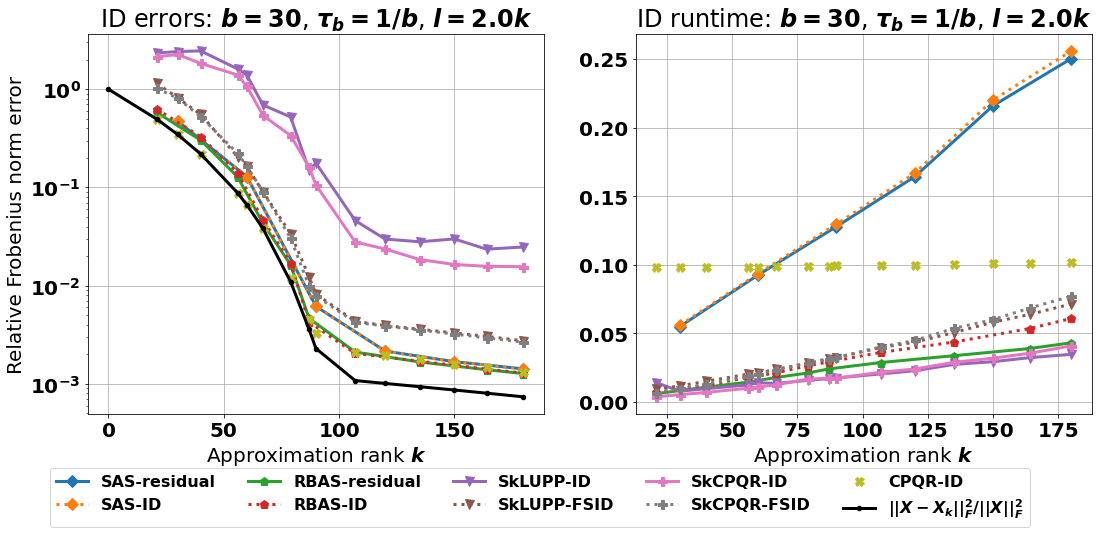

In [217]:
tag = f'id__{target_tag}'
plot_results(tag, error_time_rank, oversampling, block_size, tol_loc=tol_loc, max_x=1000, markevery=1, savefig=True)

### Naive/Robust Blockwise RP/GP

orp
k =   30, cond =   3.54e+00, min L1 =   0.00e+00, max L1 =   9.99e+02
k =   60, cond =   8.96e+00, min L1 =   0.00e+00, max L1 =   9.99e+02
k =   90, cond =   4.99e+01, min L1 =   0.00e+00, max L1 =   9.99e+02
k =  120, cond =   1.07e+02, min L1 =   0.00e+00, max L1 =   9.99e+02
k =  150, cond =   1.47e+02, min L1 =   0.00e+00, max L1 =   9.99e+02
k =  180, cond =   1.70e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  210, cond =   2.03e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  240, cond =   2.50e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  270, cond =   2.82e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
ogp
k =   30, cond =   1.41e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   60, cond =   2.43e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   90, cond =   8.85e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  120, cond =   7.81e+01, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  150, cond =   9.16e+01, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  180, co

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: borp_id uses SVD for interpolation at rank(s): 30 60 90 120 150 180 210 240 270
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


bogp
k =   30, cond =   2.53e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   60, cond =   2.90e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   90, cond =   3.31e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  120, cond =   3.69e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  150, cond =   4.02e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  180, cond =   4.65e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  210, cond =   5.27e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  240, cond =   5.96e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  270, cond =   6.76e+02, min L1 =   0.00e+00, max L1 =   1.00e+03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: bogp_id uses SVD for interpolation at rank(s): 30 60 90 120 150 180 210 240 270
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


orp
k =   30, cond =   3.54e+00, min L1 =   0.00e+00, max L1 =   9.99e+02
k =   60, cond =   8.96e+00, min L1 =   0.00e+00, max L1 =   9.99e+02
k =   90, cond =   4.99e+01, min L1 =   0.00e+00, max L1 =   9.99e+02
k =  120, cond =   1.07e+02, min L1 =   0.00e+00, max L1 =   9.99e+02
k =  150, cond =   1.47e+02, min L1 =   0.00e+00, max L1 =   9.99e+02
k =  180, cond =   1.70e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  210, cond =   2.03e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  240, cond =   2.50e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  270, cond =   2.82e+02, min L1 =   0.00e+00, max L1 =   1.00e+03
ogp
k =   30, cond =   1.41e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   60, cond =   2.43e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =   90, cond =   8.85e+00, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  120, cond =   7.81e+01, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  150, cond =   9.16e+01, min L1 =   0.00e+00, max L1 =   1.00e+03
k =  180, co

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: borp_id uses SVD for interpolation at rank(s): 21 40 56 67 79 87 107 135 164 193 222 251 270
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


bogp
k =    2, cond =   1.01e+00, min L1 =   1.08e-15, max L1 =   1.00e+03
k =    4, cond =   1.03e+00, min L1 =   1.11e-16, max L1 =   1.00e+03
k =    6, cond =   1.05e+00, min L1 =   9.43e-17, max L1 =   1.00e+03
k =    8, cond =   1.07e+00, min L1 =   7.78e-17, max L1 =   1.00e+03
k =   10, cond =   1.10e+00, min L1 =   1.49e-17, max L1 =   1.00e+03
k =   12, cond =   1.12e+00, min L1 =   1.49e-17, max L1 =   1.00e+03
k =   14, cond =   1.15e+00, min L1 =   1.49e-17, max L1 =   1.00e+03
k =   16, cond =   1.17e+00, min L1 =   1.49e-17, max L1 =   1.00e+03
k =   18, cond =   1.20e+00, min L1 =   8.67e-19, max L1 =   1.00e+03
k =   20, cond =   1.23e+00, min L1 =   8.67e-19, max L1 =   1.00e+03
k =   22, cond =   1.27e+00, min L1 =   8.67e-19, max L1 =   1.00e+03
k =   24, cond =   1.30e+00, min L1 =   8.67e-19, max L1 =   1.00e+03
k =   26, cond =   1.33e+00, min L1 =   8.67e-19, max L1 =   1.00e+03
k =   28, cond =   1.37e+00, min L1 =   8.67e-19, max L1 =   1.00e+03
k =   30, cond 

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: bogp_id uses SVD for interpolation at rank(s): 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 90 96 106 121 150 179 207 235 264 270
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


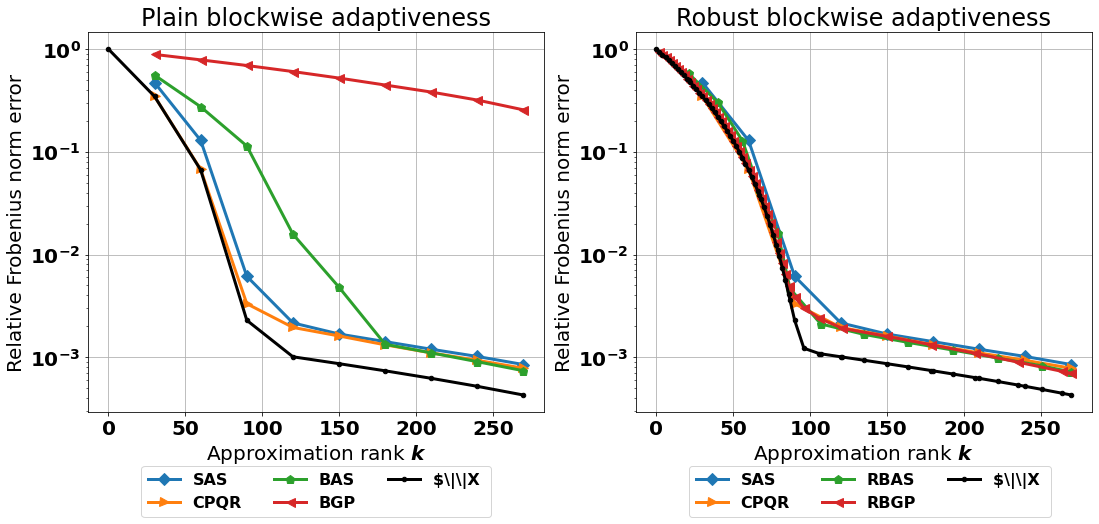

In [231]:
target_tag = 'gmm'
oversampling=2.0
block_size = 30
max_x=1000
markevery=1
savefig=True
pivot_tag='rpgp'
rank_max_ratio = 0.6

# naive blockwise
tol_loc = 0
error_time_rank = compare_interpolation_errors(targets[target_tag], b=block_size, oversampling=oversampling, orthos=[1], borthos=[1], cholid_modes=['rp','gp'], tol_loc=tol_loc, rank_max_ratio=rank_max_ratio)

lgds = []
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for (errors, _, ranks) in error_time_rank:
    ranks = ranks[ranks <= max_x]
    for err_key, err_val in errors.items():
        if "id" not in err_key and "lupp" not in err_key and "cpqr" not in err_key:
            label = plot_legends[err_key].split('-')[0]
            if tol_loc==0 and 'bo' in err_key:
                label = label[1:]
            plt.plot(ranks[:len(err_val)], err_val[:len(ranks)], plot_styler[err_key], label=label, markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Relative Frobenius norm error')
plt.title(f'Plain blockwise adaptiveness')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, -0.12), ncol=3)
lgds.append(lgd)

# robust blockwise
tol_loc = None
error_time_rank = compare_interpolation_errors(targets[target_tag], b=block_size, oversampling=oversampling, orthos=[1], borthos=[1], cholid_modes=['rp','gp'], tol_loc=tol_loc, rank_max_ratio=rank_max_ratio)

plt.subplot(1,2,2)
for (errors, _, ranks) in error_time_rank:
    ranks = ranks[ranks <= max_x]
    for err_key, err_val in errors.items():
        label = plot_legends[err_key].split('-')[0]
        if "id" not in err_key and "lupp" not in err_key and "cpqr" not in err_key:
            plt.plot(ranks[:len(err_val)], err_val[:len(ranks)], plot_styler[err_key], label=label, markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Relative Frobenius norm error')
plt.title(f'Robust blockwise adaptiveness')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, -0.12), ncol=3)
lgds.append(lgd)

target_tag = f'id__{target_tag}'
if savefig:
    plt.savefig(f'../figs/{target_tag}__b{block_size:d}__os{oversampling}__{pivot_tag}.png', bbox_extra_artists=lgds, bbox_inches='tight')    

## Gaussian-poly1

In [169]:
target_tag = 'Gaussian-poly0'
oversampling=2.0
block_size = 30
tol_loc = None
error_time_rank = compare_interpolation_errors(targets[target_tag], b=block_size, oversampling=oversampling, orthos=[1], borthos=[1], cholid_modes=['rp'], tol_loc=tol_loc)

orp
k =   30, cond =   2.67e+00, min L1 =   0.00e+00, max L1 =   3.60e-01
k =   60, cond =   5.03e+00, min L1 =   0.00e+00, max L1 =   3.60e-01
k =   90, cond =   7.63e+00, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  120, cond =   1.09e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  150, cond =   1.23e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  180, cond =   1.40e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  210, cond =   1.51e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  240, cond =   1.65e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  270, cond =   1.75e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  300, cond =   1.84e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  330, cond =   1.96e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  360, cond =   2.03e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
k =  390, cond =   2.10e+01, min L1 =   0.00e+00, max L1 =   3.60e-01
borp
k =   29, cond =   2.48e+00, min L1 =   0.00e+00, max L1 =   3.63e-01
k =   58, c

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: borp_id uses SVD for interpolation at rank(s): 29 58 86 114 142 171 200 229 258 287 316 345 374 390
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


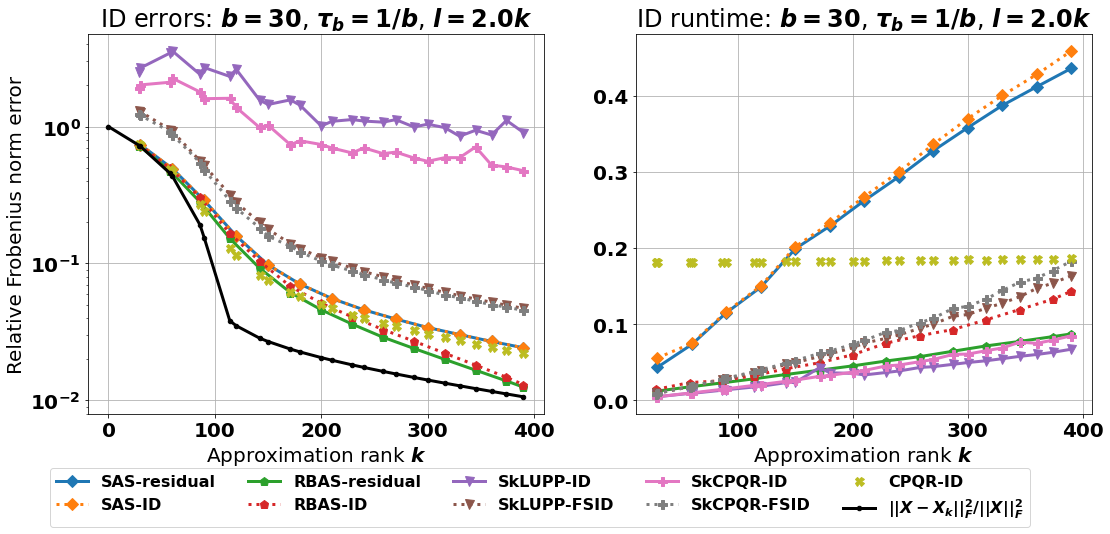

In [170]:
tag = f'id__{target_tag}'
plot_results(tag, error_time_rank, oversampling, block_size, tol_loc=tol_loc, max_x=1000, markevery=1, savefig=True)

## Gaussian-exp

In [187]:
target_tag = 'Gaussian-exp'
oversampling=2.0
block_size = 30
tol_loc = None
error_time_rank = compare_interpolation_errors(targets[target_tag], b=block_size, oversampling=oversampling, orthos=[1], borthos=[1,], cholid_modes=['rp'], tol_loc=tol_loc)

orp
k =   30, cond =   3.09e+00, min L1 =   0.00e+00, max L1 =   3.52e-01
k =   60, cond =   5.55e+00, min L1 =   0.00e+00, max L1 =   3.52e-01
k =   90, cond =   1.60e+01, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  120, cond =   1.17e+03, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  150, cond =   6.41e+04, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  180, cond =   6.81e+04, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  210, cond =   7.03e+04, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  240, cond =   7.30e+04, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  270, cond =   7.59e+04, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  300, cond =   7.79e+04, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  330, cond =   8.03e+04, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  360, cond =   8.21e+04, min L1 =   0.00e+00, max L1 =   3.52e-01
k =  390, cond =   8.32e+04, min L1 =   0.00e+00, max L1 =   3.52e-01
borp
k =   29, cond =   3.01e+00, min L1 =   0.00e+00, max L1 =   3.47e-01
k =   57, c

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: borp_id uses SVD for interpolation at rank(s): 29 57 84 104 111 117 123 130 137 159 187 216 245 274 303 332 361 389 390
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


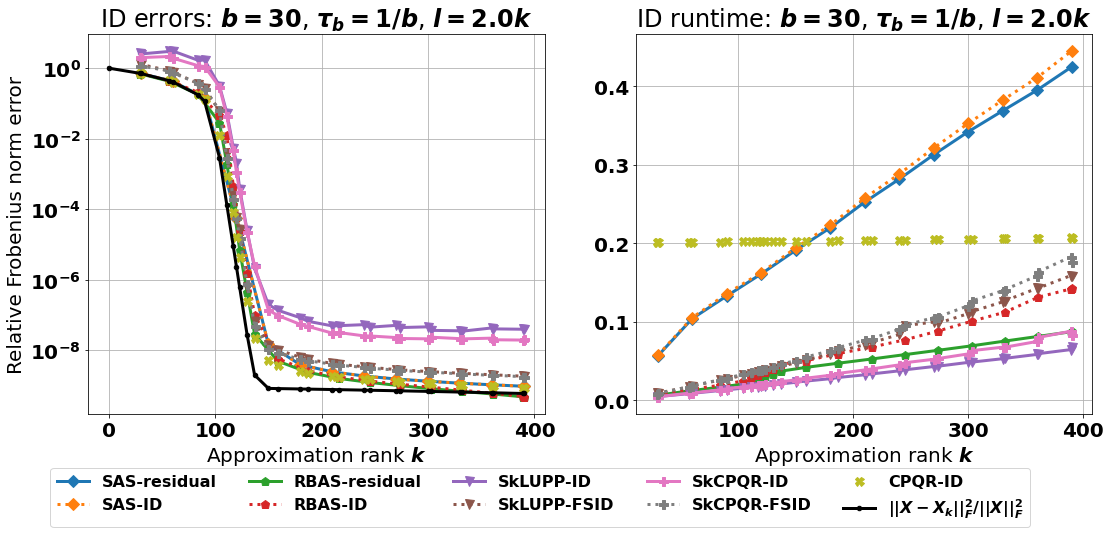

In [188]:
tag = f'id__{target_tag}'
plot_results(tag, error_time_rank, oversampling, block_size, tol_loc=tol_loc, max_x=1000, markevery=1, savefig=True)

## SNN-r20a10

In [193]:
target_tag = 'SNN_m1000n1000r100a10'
oversampling=2.0
block_size = 30
tol_loc = None
error_time_rank = compare_interpolation_errors(targets[target_tag], b=block_size, oversampling=oversampling, orthos=[1], borthos=[1,], cholid_modes=['rp'], tol_loc=tol_loc)

orp
k =   30, cond =   1.85e+02, min L1 =   0.00e+00, max L1 =   6.28e+01
k =   60, cond =   5.94e+02, min L1 =   0.00e+00, max L1 =   7.07e+01
k =   90, cond =   2.70e+03, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  120, cond =   6.12e+03, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  150, cond =   8.80e+03, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  180, cond =   1.15e+04, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  210, cond =   1.48e+04, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  240, cond =   1.71e+04, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  270, cond =   2.07e+04, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  300, cond =   2.48e+04, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  330, cond =   2.98e+04, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  360, cond =   3.54e+04, min L1 =   0.00e+00, max L1 =   7.07e+01
k =  390, cond =   4.11e+04, min L1 =   0.00e+00, max L1 =   7.07e+01
borp
k =    3, cond =   7.74e+00, min L1 =   3.34e-15, max L1 =   5.70e+01
k =   18, c

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: borp_id uses SVD for interpolation at rank(s): 3 18 44 70 93 114 142 170 199 228 257 286 315 344 373 390
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


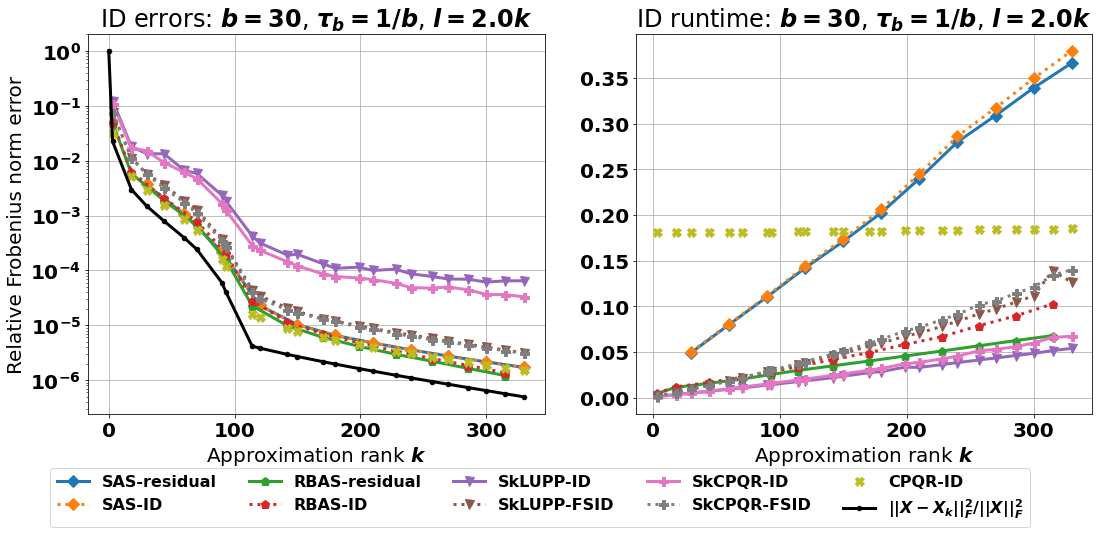

In [194]:
tag = f'id__{target_tag}'
plot_results(tag, error_time_rank, oversampling, block_size, tol_loc=tol_loc, max_x=330, markevery=1, savefig=True)

## SNN-r20a1

In [195]:
target_tag = 'SNN_m1000n1000r100a1'
oversampling=2.0
block_size = 30
tol_loc = None
error_time_rank = compare_interpolation_errors(targets[target_tag], b=block_size, oversampling=oversampling, orthos=[1], borthos=[1,], cholid_modes=['rp'], tol_loc=tol_loc)

orp
k =   30, cond =   1.25e+02, min L1 =   0.00e+00, max L1 =   5.29e+00
k =   60, cond =   2.81e+02, min L1 =   0.00e+00, max L1 =   5.29e+00
k =   90, cond =   4.29e+02, min L1 =   0.00e+00, max L1 =   5.29e+00
k =  120, cond =   6.36e+02, min L1 =   0.00e+00, max L1 =   5.29e+00
k =  150, cond =   8.28e+02, min L1 =   0.00e+00, max L1 =   5.29e+00
k =  180, cond =   1.06e+03, min L1 =   0.00e+00, max L1 =   6.02e+00
k =  210, cond =   1.35e+03, min L1 =   0.00e+00, max L1 =   6.02e+00
k =  240, cond =   1.58e+03, min L1 =   0.00e+00, max L1 =   6.02e+00
k =  270, cond =   1.95e+03, min L1 =   0.00e+00, max L1 =   6.02e+00
k =  300, cond =   2.27e+03, min L1 =   0.00e+00, max L1 =   6.02e+00
k =  330, cond =   2.68e+03, min L1 =   0.00e+00, max L1 =   6.02e+00
k =  360, cond =   3.10e+03, min L1 =   0.00e+00, max L1 =   6.02e+00
k =  390, cond =   3.77e+03, min L1 =   0.00e+00, max L1 =   6.02e+00
borp
k =    3, cond =   9.43e+00, min L1 =   1.78e-15, max L1 =   5.98e+00
k =   24, c

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: borp_id uses SVD for interpolation at rank(s): 3 24 51 79 107 136 165 194 223 252 281 310 339 368 389 390
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


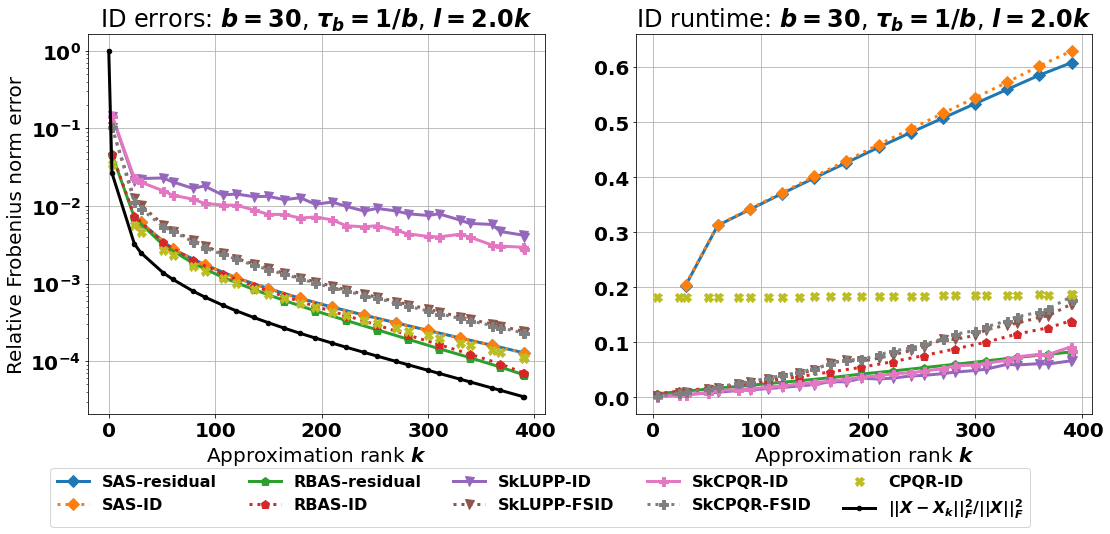

In [196]:
tag = f'id__{target_tag}'
plot_results(tag, error_time_rank, oversampling, block_size, tol_loc=tol_loc, max_x=1000, markevery=1, savefig=True)

## MNIST

In [197]:
target_tag = 'MNIST'
oversampling=2.0
block_size = 30
tol_loc = None
error_time_rank = compare_interpolation_errors(targets[target_tag], b=block_size, oversampling=oversampling, orthos=[1], borthos=[1,], cholid_modes=['rp'], tol_loc=tol_loc)

orp
k =   30, cond =   1.23e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =   60, cond =   2.25e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =   90, cond =   3.28e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  120, cond =   4.65e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  150, cond =   6.08e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  180, cond =   8.20e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  210, cond =   1.08e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  240, cond =   1.48e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  270, cond =   1.82e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  300, cond =   2.42e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
borp
k =   26, cond =   9.37e+00, min L1 =   0.00e+00, max L1 =   1.00e+00
k =   53, cond =   1.92e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =   81, cond =   5.94e+17, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  109, cond =   5.94e+17, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  137, c

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: borp_id uses SVD for interpolation at rank(s): 26 53 81 109 137 165 193 221 249 277 298 300
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


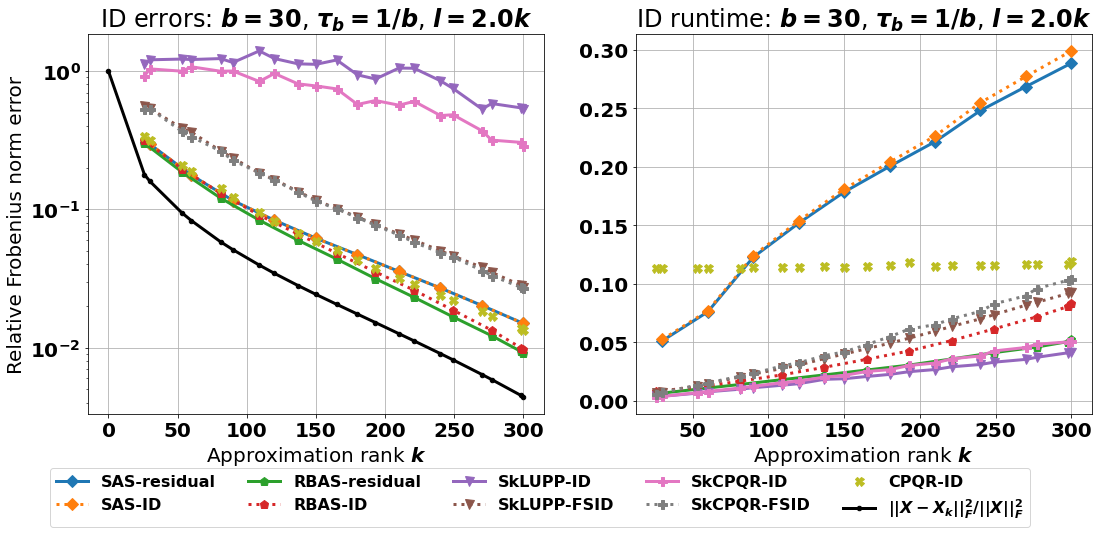

In [198]:
tag = f'id__{target_tag}'
plot_results(tag, error_time_rank, oversampling, block_size, tol_loc=tol_loc, max_x=1000, markevery=1, savefig=True)

## CIFAR-10

In [199]:
target_tag = 'cifar10'
oversampling=2.0
block_size = 30
tol_loc = None
error_time_rank = compare_interpolation_errors(targets[target_tag], b=block_size, oversampling=oversampling, orthos=[1], borthos=[1,], cholid_modes=['rp'], tol_loc=tol_loc)

orp
k =   30, cond =   3.17e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =   60, cond =   5.56e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =   90, cond =   8.29e+01, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  120, cond =   1.08e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  150, cond =   1.34e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  180, cond =   1.64e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  210, cond =   2.08e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  240, cond =   2.78e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  270, cond =   3.20e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  300, cond =   3.55e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  330, cond =   3.93e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  360, cond =   4.30e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
k =  390, cond =   4.73e+02, min L1 =   0.00e+00, max L1 =   1.00e+00
borp
k =   16, cond =   1.59e+01, min L1 =   8.67e-19, max L1 =   1.00e+00
k =   43, c

/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_56520/135349530.py:235: UserWarning: borp_id uses SVD for interpolation at rank(s): 16 43 70 97 124 150 177 204 231 258 285 313 339 367 387 390
  warnings.warn(f"{tag} uses SVD for interpolation at rank(s): " + ' '.join(map(str, use_svd)))


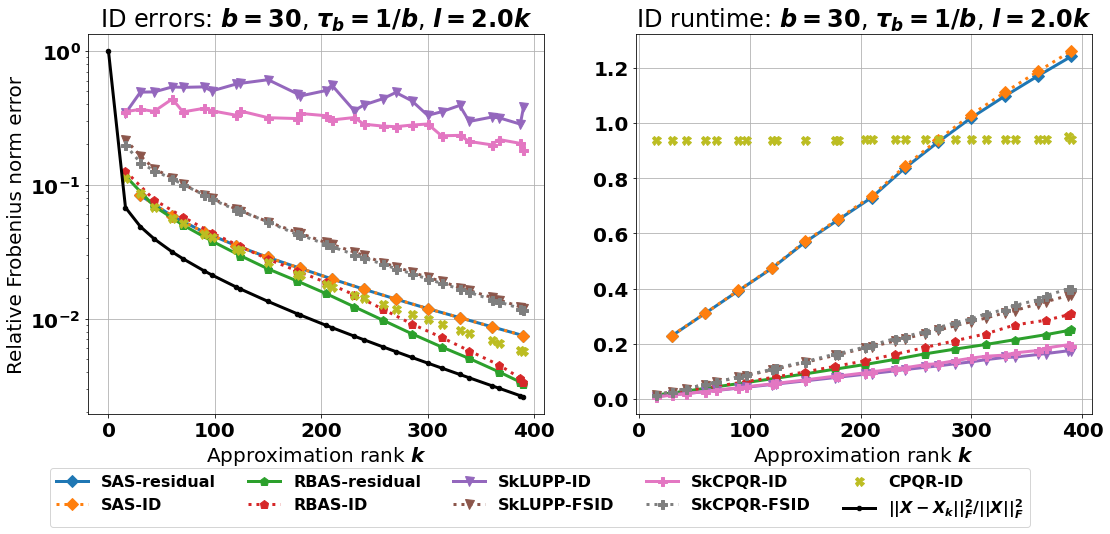

In [200]:
tag = f'id__{target_tag}'
plot_results(tag, error_time_rank, oversampling, block_size, tol_loc=tol_loc, max_x=900, markevery=1, savefig=True)

# Test skeletonization

## Gaussian-poly1

In [ ]:
target_tag = 'Gaussian-poly1'
oversampling=1.0
block_size = 40
error_time_rank = compare_skeletonization_errors(targets[target_tag], b=40, oversampling=oversampling)